# Compare models

## Loading feature sets

In [1]:
# defining constants
corpus_folder='corpus'
metadata_fn='corpus/metadata.txt'
target_col='sample_name'

In [2]:
# open all metadata and featuresets
import pandas as pd
df_meta=pd.read_csv(metadata_fn,encoding='utf-8',sep='\t').set_index('fn')
df_feat_poesy = pd.read_csv('featuresets/data.feats.poesy.sonnets-vs-nonsonnets.txt',encoding='utf-8',sep='\t').set_index('fn')
df_feat_freqs = pd.read_csv('featuresets/data.feats.wordfreqs.sonnets-vs-nonsonnets.txt',encoding='utf-8',sep='\t').set_index('_fn')
ALL_DFS = [df_meta,df_feat_freqs,df_feat_poesy]
FEAT_DFs = [df_feat_freqs,df_feat_poesy]

In [3]:
# hack, fix for wrong path
for df in ALL_DFS:
    df.index = [unicode(idx).replace('corpus2/','corpus/') for idx in df.index]

In [4]:
df_all = df_meta.join(df_feat_poesy,rsuffix='_poesy',how='inner').join(df_feat_freqs,rsuffix='_freqs',how='inner')
shared_index = [idx for idx in df_all.index if type(df_meta.loc[idx][target_col])==unicode]

In [5]:
len(shared_index)

1280

## Classify!

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut
import numpy as np

def classify(X,y,return_probs=False):
    loo=LeaveOneOut()
    all_predictions=[]
    for train_index, test_index in loo.split(X):
        clf = LogisticRegression()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        clf.fit(X_train,y_train)
        if return_probs:
            predictions=clf.predict_proba(X_test)
            prediction=predictions[0][1]
        else:
            predictions=clf.predict(X_test)
            prediction=predictions[0]
        all_predictions+=[prediction]
    return all_predictions

In [129]:
def classify_feat_df(df_feat,return_probs=False):
    y=np.array([df_meta.loc[idx][target_col] for idx in shared_index])
    X=df_feat.loc[shared_index].select_dtypes('number').fillna(0).values
    return classify(X,y,return_probs=return_probs)

In [76]:
df_results=pd.DataFrame(index=shared_index)
df_results[target_col]=df_meta.loc[shared_index][target_col]

In [77]:
df_results['prediction_freqs']=classify_feat_df(df_feat_freqs)

>> accuracy: 0.6515625


In [78]:
df_results['prediction_poesy']=classify_feat_df(df_feat_poesy)

>> accuracy: 0.84453125


In [79]:
df_results['prediction_poesy+freqs']=classify_feat_df(df_feat_poesy.loc[shared_index].join(df_feat_freqs.loc[shared_index]))

>> accuracy: 0.81875


## Rule-based model

In [87]:
def poesy_rule_based_classifier_for_sonnets(row):
    if row['num_lines']!=14: return 'NotSonnets'
    if row['meter_type_scheme']!='iambic': return 'NotSonnets'
    if row['beat_scheme_repr']!='Pentameter': return 'NotSonnets'
    if not 'sonnet' in row['rhyme_scheme_name'].lower(): return 'NotSonnets'
    return 'Sonnets'

In [185]:
def loose_poesy_rule_based_classifier_for_sonnets(row,certainty_threshold=0.75,return_probs=False):
    counts_in_its_favor = []
    counts_in_its_favor += [row['num_lines']==14]
    counts_in_its_favor += [row['meter_type_scheme']=='iambic']
    counts_in_its_favor += [row['beat_scheme_repr']=='Pentameter']
    counts_in_its_favor += ['sonnet' in unicode(row['rhyme_scheme_name']).lower()]
    counts_in_its_favor += ['sonnet' in unicode(row['rhyme_scheme_name']).lower()] # counts for double
    
    counts = [int(x) for x in counts_in_its_favor]
    certainty = sum(counts)/float(len(counts)) if counts else 0.0
    if return_probs: return certainty
    return 'Sonnets' if certainty>certainty_threshold else 'NotSonnets'

In [102]:
df_results['prediction_rule-based']=[poesy_rule_based_classifier_for_sonnets(row) for ind,row in df_feat_poesy.loc[shared_index].iterrows()]

In [103]:
df_results['prediction_loosely_rule-based']=[loose_poesy_rule_based_classifier_for_sonnets(row) for ind,row in df_feat_poesy.loc[shared_index].iterrows()]

In [104]:
#df_results

## Compare precision/recall

In [105]:
from sklearn.metrics import precision_recall_fscore_support

In [106]:
summaryld=[]
for col in df_results.columns:
    if col==target_col: continue
    sdx={}
    sdx['precision'],sdx['recall'],sdx['fscore'],sdx['support']=precision_recall_fscore_support(df_results[target_col], df_results[col], labels=['Sonnets'])
    for k,v in sdx.items(): sdx[k]=v[0]
    sdx['model']=col.replace('prediction_','').replace('_',' ').title()
    summaryld+=[sdx]
summarydf=pd.DataFrame(summaryld)
summarydf=summarydf[['model','precision','recall','fscore']].sort_values('fscore',ascending=False).set_index('model')

In [107]:
summarydf.round(3)

,precision,recall,fscore
model,,,
Poesy,0.825,0.873,0.848
Poesy+Freqs,0.814,0.824,0.819
Loosely Rule-Based,0.717,0.840,0.773
Rule-Based,0.887,0.605,0.720
Freqs,0.648,0.656,0.652


## Precision/Recall curves

In [325]:
df_probs=pd.DataFrame(index=shared_index)

In [326]:
df_probs['poesy_prob_sonnet']=classify_feat_df(df_feat_poesy,return_probs=True)

In [327]:
df_probs['freqs_prob_sonnet']=classify_feat_df(df_feat_freqs,return_probs=True)

In [328]:
df_probs['loosely_rule-based_prob_sonnet']=[
    loose_poesy_rule_based_classifier_for_sonnets(row,return_probs=True)
    for ind,row in df_feat_poesy.loc[shared_index].iterrows()
]

In [329]:
df_probs['rule-based_prob_sonnet']=[
    float(int(poesy_rule_based_classifier_for_sonnets(row)=='Sonnets'))
    for ind,row in df_feat_poesy.loc[shared_index].iterrows()
]

In [330]:
df_probs[target_col]=df_meta.loc[shared_index][target_col]

In [331]:
df_probs.head()

,poesy_prob_sonnet,freqs_prob_sonnet,loosely_rule-based_prob_sonnet,rule-based_prob_sonnet,sample_name
corpus/NotSonnets/Z200132903.txt,0.000698,0.180874,0.6,0.0,NotSonnets
corpus/NotSonnets/Z200136310.txt,0.015533,0.001080,0.2,0.0,NotSonnets
corpus/NotSonnets/Z200136454.txt,0.698980,0.038952,1.0,1.0,NotSonnets
corpus/NotSonnets/Z200137154.txt,0.048315,0.936111,0.4,0.0,NotSonnets
corpus/NotSonnets/Z200145428.txt,0.075615,0.963485,0.4,0.0,NotSonnets


In [332]:
from sklearn.metrics import precision_recall_curve
def prcurve(y_true,y_scores):
    return precision_recall_curve(list(y_true), y_scores.values, pos_label='Sonnets')

In [333]:
#prcurve(df_probs[target_col], df_probs['poesy_prob_sonnet'])

In [334]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]
#plt.figure(figsize=(600, ), dpi= 80, facecolor='w', edgecolor='k')

def plot_prcurve(y_true,y_scores,label,color='b'):
    from sklearn.utils.fixes import signature

    precision, recall, _ = prcurve(y_true,y_scores)
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score([int(yx=='Sonnets') for yx in y_true], y_scores)
    label = label.replace('_prob_sonnet','') + ' (AP=%s)' % round(average_precision,2)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color=color, alpha=1.0,
             where='post',label=label)
    #plt.fill_between(recall, precision, alpha=0.2, color=color, **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')

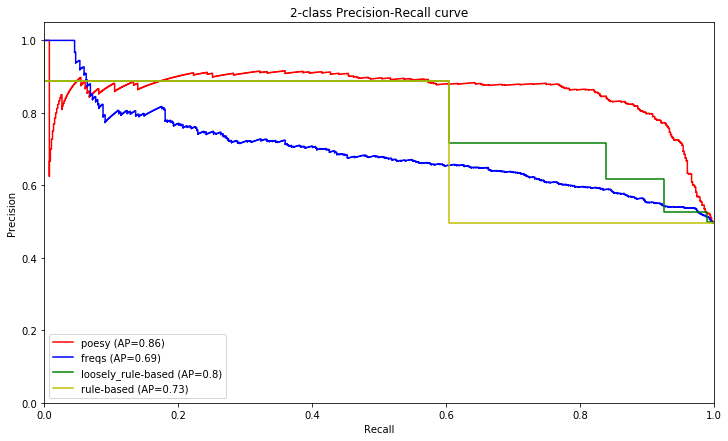

In [335]:
#plot_prcurve(df_probs[target_col], df_probs['poesy_prob_sonnet'])
colors=['r','b','g','y','k','c']
for i,col in enumerate(df_probs):
    if col==target_col: continue
    plot_prcurve(df_probs[target_col], df_probs[col],color=colors[i],label=col)
plt.legend()
plt.savefig('figure.png')
plt.show()